#### Look at the MEI columns and remove those which won't help as predictors

In [1]:
from getConfig   import getConfig
from getData     import getData
from plotColumns import plotColumns
from genFeatures import genFeatures

In [2]:
config = getConfig()
df = getData(config)

In [3]:
# MEI data is in columns 14-89
def getMEI(df):
    return df.iloc[:,13:89]

In [4]:
def removeDups(df):
    print("removing duplicate columns")
    avg = df.mean()
    dups = avg.loc[avg.duplicated()].index.values
    for x in dups:
        print("- ", x)
    keep = avg.loc[~avg.duplicated()]
    df = df[list(keep.index.values)]
    return df

In [5]:
def removeAnnual(df):
    print("removing Annual columns")
    for col in df.columns:
        unique = np.unique(df[col])
        if unique.shape[0] < 10:
            del df[col]
            print("- ", col)
    return df

In [6]:
def getTargets(df):
    targets = ["Valmont_Net_Sales_Pounds", "Valmont_Net_Sales"]
    targets = df[targets]
    targets.columns = ["Volume", "Revenue"]
    return targets

In [7]:
def renameCols(df):
    d = {}
    cols = df.columns
    
    for col in cols:
        x = col[4:]
        n = x.find("_")
        key = x[:n]
        val = x[n+3:]
        d[key] = val
        key = "MEI_" + key
        df.rename({col:key},axis="columns", inplace=True)
    return df, d

In [8]:
def getMEIname(key):
    return meiDict[key]

In [9]:
def getCorrelation(MEI, targets):
    ''' Correlation between MacroEconomic Indicators and Valmont Vol and Rev '''
    keep = []
    for tgt in targets.columns:
        tgt = targets[tgt]       # This is either Vol or Rev
        for col in MEI.columns:
            mei = MEI[col]
            corr = tgt.corr(mei)
            if corr > 0.35:
                keep.append(col)
    keep = set(keep)

    # All the columns in "keep" are minimally correlated with either Vol or Revenue
    print("Found {} potential predictors".format(len(keep)))
    print("\n{:<20}{:<6}{}".format("Column", "Vol", "Rev"))
    for x in keep:
        Vcorr = MEI[x].corr(targets["Volume"])
        Rcorr = MEI[x].corr(targets["Revenue"])
        print("{:<20}{:<6.2f}{:.2f}".format(x, Vcorr, Rcorr))
    return keep

In [10]:
def getMEIcorr(MEI, keep):
    ''' Check the collinearity of the remaining MEIs '''
    corrDF = MEI[list(keep)]
    corrDF = corrDF.corr()

    for col in corrDF.columns:
        s = corrDF.loc[col]
        count = sum(s>0.85)
        if count > 1:
            print(col, count)
    return corrDF

In [11]:
MEI = getMEI(df)
# Static column
del MEI["Avg_4___Ecri_Business_Cycle_Dates___United_States"]
MEI = removeDups(MEI)
MEI = removeAnnual(MEI)
MEI, meiDict = renameCols(MEI)
MEI = genFeatures(MEI)
targets = getTargets(df)

removing duplicate columns
-  Avg_41___CPI_U__All_Items_Less_Food_and_Energy__1982_84_100__Index___United_Sta
-  Avg_60___US_MW_Dom_HRC_Steel_Near_Term__NYM___st____Price
-  Avg_61___Crude_Steel_Production__United_States__Thous_Metric_Tons___United_Stat
removing Annual columns
-  Avg_13___Median_Household_Income__National__Adjusted_to_2013_U_S_Dollars___Unit
-  Avg_30___Average_Hours_At_Work_in_All_Industries__Total__SA__Hours___United_Sta
-  Avg_31___Average_Weekly_Hours_of_All_Employees__Total_Private__SA__Hours__Hours
-  Avg_32___Average_Weekly_Overtime_Hours_of_Production_and_Nonsupervisory_Employe
-  Avg_39___Demographic_Indicators__Births__All_Races___Origins__Number___United_S


In [12]:
# Check for correlation between MEI and Targets  (Volume and Revenue, separately)
keep = getCorrelation(MEI, targets)

Found 16 potential predictors

Column              Vol   Rev
MEI_27              0.35  0.14
MEI_71_M%chg_L6     0.35  0.28
MEI_63              0.37  0.26
MEI_28              0.38  0.17
MEI_36_Q%chg_L1     0.67  0.75
MEI_9_M%chg_L2      0.35  0.37
MEI_74_A%chg        0.36  0.27
MEI_70_M%chg_L6     0.36  0.30
MEI_10_M%chg_L5     0.39  0.41
MEI_26_M%chg_L5     0.53  0.57
MEI_1               0.40  0.25
MEI_71_M%chg_L0     0.35  0.31
MEI_3               0.40  0.22
MEI_26_M%chg_L2     0.52  0.55
MEI_74_M%chg_L5     0.36  0.31
MEI_9_M%chg_L5      0.44  0.45


##### Check for collinearity among the potential predictors

In [17]:
MEIcorr = getMEIcorr(MEI, keep)

MEI_27 2
MEI_71_M%chg_L6 2
MEI_28 3
MEI_70_M%chg_L6 2
MEI_1 2
MEI_3 3


In [14]:
getMEIname("63")

'High_Grade_Copper__NYM___lbs__Continuous___Futures___Price___Close'

In [19]:
# For an MEI, get correlations with other MEIs
MEIcorr.loc["MEI_70_M%chg_L6"]

MEI_27             0.049351
MEI_71_M%chg_L6    0.948563
MEI_63             0.106865
MEI_28             0.043549
MEI_36_Q%chg_L1    0.258014
MEI_9_M%chg_L2     0.169455
MEI_74_A%chg       0.197592
MEI_70_M%chg_L6    1.000000
MEI_10_M%chg_L5    0.131236
MEI_26_M%chg_L5   -0.030779
MEI_1             -0.020950
MEI_71_M%chg_L0    0.031586
MEI_3              0.117011
MEI_26_M%chg_L2    0.217184
MEI_74_M%chg_L5    0.714215
MEI_9_M%chg_L5     0.015824
Name: MEI_70_M%chg_L6, dtype: float64

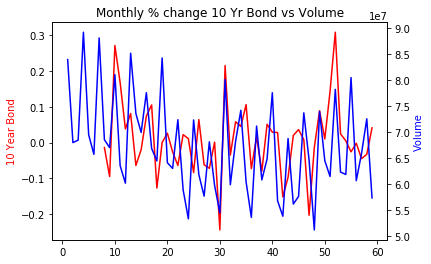

In [33]:
a = MEI["MEI_70_M%chg_L6"]
b = targets["Volume"]


plotColumns(a,b, "10 Year Bond", "Volume", "Monthly % change 10 Yr Bond vs Volume")

In [20]:
# Remove any highly correlated
keep.remove("MEI_27")
keep.remove("MEI_3")
keep.remove("MEI_70_M%chg_L6")

In [21]:
print("Final list of {} predictors:".format(len(keep)))
for k in keep:
    print("  -",k)

Final list of 13 predictors:
  - MEI_71_M%chg_L6
  - MEI_63
  - MEI_28
  - MEI_36_Q%chg_L1
  - MEI_9_M%chg_L2
  - MEI_74_A%chg
  - MEI_10_M%chg_L5
  - MEI_26_M%chg_L5
  - MEI_1
  - MEI_71_M%chg_L0
  - MEI_26_M%chg_L2
  - MEI_74_M%chg_L5
  - MEI_9_M%chg_L5


In [23]:
MEI = MEI[list(keep)]
MEI["Month"] = df["Month"]
final = pd.concat([MEI, targets],axis=1)

final.to_csv(config["dataLoc"]+"final.csv", index=False)